# Introduction

We tackle the problem of OCR post processing. In OCR, we map the image form of the document into the text domain. This is done first using an CNN+LSTM+CTC model, in our case based on tesseract. Since this output maps only image to text, we need something on top to validate and correct language semantics.

The idea is to build a language model, that takes the OCRed text and corrects it based on language knowledge. The langauge model could be:
- Char level: the aim is to capture the word morphology. In which case it's like a spelling correction system.
- Word level: the aim is to capture the sentence semnatics. But such systems suffer from the OOV problem.
- Fusion: to capture semantics and morphology language rules. The output has to be at char level, to avoid the OOV. However, the input can be char, word or both.

The fusion model target is to learn:

    p(char | char_context, word_context)

In this workbook we use seq2seq vanilla Keras implementation, adapted from the lstm_seq2seq example on Eng-Fra translation task. The adaptation involves:

- Adapt to spelling correction, on char level
- Pre-train on a noisy, medical sentences
- Fine tune a residual, to correct the mistakes of tesseract 
- Limit the input and output sequence lengths
- Enusre teacher forcing auto regressive model in the decoder
- Limit the padding per batch
- Learning rate schedule
- Bi-directional LSTM Encoder
- Bi-directional GRU Encoder


# Imports

In [1]:
from __future__ import print_function
import tensorflow as tf
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, GRU, Dot, TimeDistributed, Activation, Embedding
from keras import optimizers
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Utility functions

In [2]:
# Limit gpu allocation. allow_growth, or gpu_fraction
def gpu_alloc():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))

In [3]:
gpu_alloc()

In [4]:
def calculate_WER_sent(gt, pred):
    '''
    calculate_WER('calculating wer between two sentences', 'calculate wer between two sentences')
    '''
    gt_words = gt.lower().split(' ')
    pred_words = pred.lower().split(' ')
    d = np.zeros(((len(gt_words) + 1), (len(pred_words) + 1)), dtype=np.uint8)
    # d = d.reshape((len(gt_words)+1, len(pred_words)+1))

    # Initializing error matrix
    for i in range(len(gt_words) + 1):
        for j in range(len(pred_words) + 1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(gt_words) + 1):
        for j in range(1, len(pred_words) + 1):
            if gt_words[i - 1] == pred_words[j - 1]:
                d[i][j] = d[i - 1][j - 1]
            else:
                substitution = d[i - 1][j - 1] + 1
                insertion = d[i][j - 1] + 1
                deletion = d[i - 1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)
    return d[len(gt_words)][len(pred_words)]

In [5]:
def calculate_WER(gt, pred):
    '''

    :param gt: list of sentences of the ground truth
    :param pred: list of sentences of the predictions
    both lists must have the same length
    :return: accumulated WER
    '''
#    assert len(gt) == len(pred)
    WER = 0
    nb_w = 0
    for i in range(len(gt)):
        #print(gt[i])
        #print(pred[i])
        WER += calculate_WER_sent(gt[i], pred[i])
        nb_w += len(gt[i])

    return WER / nb_w

In [6]:
# Artificial noisy spelling mistakes
def noise_maker(sentence, threshold):
    '''Relocate, remove, or add characters to create spelling mistakes'''
    letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m',
           'n','o','p','q','r','s','t','u','v','w','x','y','z',]
    noisy_sentence = []
    i = 0
    while i < len(sentence):
        random = np.random.uniform(0, 1, 1)
        # Most characters will be correct since the threshold value is high
        if random < threshold:
            noisy_sentence.append(sentence[i])
        else:
            new_random = np.random.uniform(0, 1, 1)
            # ~33% chance characters will swap locations
            if new_random > 0.67:
                if i == (len(sentence) - 1):
                    # If last character in sentence, it will not be typed
                    continue
                else:
                    # if any other character, swap order with following character
                    noisy_sentence.append(sentence[i + 1])
                    noisy_sentence.append(sentence[i])
                    i += 1
            # ~33% chance an extra lower case letter will be added to the sentence
            elif new_random < 0.33:
                random_letter = np.random.choice(letters, 1)[0]
                noisy_sentence.append(random_letter)
                noisy_sentence.append(sentence[i])
            # ~33% chance a character will not be typed
            else:
                pass
        i += 1

    return ''.join(noisy_sentence)

In [7]:
def load_data_with_gt(file_name, num_samples, max_sent_len, min_sent_len, delimiter='\t', gt_index=1, prediction_index=0):
    '''Load data from txt file, with each line has: <TXT><TAB><GT>. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    for row in open(file_name, encoding='utf8'):
        if cnt < num_samples :
            #print(row)
            sents = row.split(delimiter)
            input_text = sents[prediction_index]
            
            target_text = '\t' + sents[gt_index] + '\n'
            if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                cnt += 1
                
                input_texts.append(input_text)
                target_texts.append(target_text)
                gt_texts.append(sents[gt_index])
    return input_texts, target_texts, gt_texts

In [8]:
def load_data_with_noise(file_name, num_samples, noise_threshold, max_sent_len, min_sent_len):
    '''Load data from txt file, with each line has: <TXT>. The GT is just a noisy version of TXT. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    while cnt < num_samples :
        #for row in open(file_name, encoding='utf8'):
        for row in open(file_name):
            if cnt < num_samples :
                sents = row.split("\t")
                input_text = noise_maker(sents[1], noise_threshold)
                input_text = input_text[:-1]

                target_text = '\t' + sents[1] + '\n'            
                if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                    cnt += 1
                    input_texts.append(input_text)
                    target_texts.append(target_text)
                    gt_texts.append(target_text[1:-1])
                    
    return input_texts, target_texts, gt_texts

In [9]:
def build_vocab(all_texts):
    '''Build vocab dictionary to victorize chars into ints'''
    vocab_to_int = {}
    count = 0 # Start index for any char will be 1, as 0 is masked by the Embedding/Masking layer
    codes = ['UNK', ' ', '\t','\n']# Start 'UNK' at the first entry, to keep its index=0 to be masked
    for code in codes:
        if code not in vocab_to_int:
            vocab_to_int[code] = count
            count += 1    
    
    for sentence in all_texts:
        for char in sentence:
            if char not in vocab_to_int:
                vocab_to_int[char] = count
                count += 1


    '''''Build inverse translation from int to char'''
    int_to_vocab = {}
    for character, value in vocab_to_int.items():
        int_to_vocab[value] = character
        
    return vocab_to_int, int_to_vocab

In [10]:
def vectorize_data(input_texts, target_texts, max_encoder_seq_length, num_encoder_tokens, vocab_to_int):
    '''Prepares the input text and targets into the proper seq2seq numpy arrays'''
    encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length),
    dtype='float32')
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length),
        dtype='float32')
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_encoder_tokens),
        dtype='float32')

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        for t, char in enumerate(input_text):
            # c0..cn
            encoder_input_data[i, t] = vocab_to_int[char]
        for t, char in enumerate(target_text):
            # c0'..cm'
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t] = vocab_to_int[char]
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, vocab_to_int[char]] = 1.
                
    return encoder_input_data, decoder_input_data, decoder_target_data

In [11]:
def decode_gt_sequence(input_seq, int_to_vocab):

    stop_condition = False
    decoded_sentence = ''
    for i in range(input_seq.shape[1]):
        
        # Sample a token
        sampled_token_index = input_seq[0][i]
        sampled_char = int_to_vocab[sampled_token_index]
        decoded_sentence += sampled_char

    return decoded_sentence


In [12]:
def decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab):
    # Encode the input as state vectors.
    encoder_outputs, h, c  = encoder_model.predict(input_seq)
    states_value = [h,c]
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = vocab_to_int['\t']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    #print(input_seq)
    while not stop_condition:
        #print(target_seq)
        output_tokens, h, c = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value)

        # Sample a token
        #print(output_tokens.shape)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        #print(sampled_token_index)
        sampled_char = int_to_vocab[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence


In [13]:
def build_model(num_encoder_tokens, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None,), dtype='float32')
    encoder_inputs_ = Embedding(num_encoder_tokens, num_encoder_tokens,                           
                            weights=[np.eye(num_encoder_tokens)],
                            mask_zero=True, trainable=False)(encoder_inputs)    
    #encoder_inputs = Input(shape=(None, num_encoder_tokens))
    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]# Bi GRU, LSTM, BHi LSTM
    print(encoder_states)
    
    decoder_inputs = Input(shape=(None,))
    decoder_inputs_ = Embedding(num_encoder_tokens, num_encoder_tokens,                           
                            weights=[np.eye(num_encoder_tokens)],
                            mask_zero=True, trainable=False)(decoder_inputs)    
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)# Bi LSTM
    
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs_, initial_state=encoder_states)

    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    print(decoder_outputs)
    print(encoder_outputs)
    att_dot = Dot(axes=[2, 2])
    attention = att_dot([decoder_outputs, encoder_outputs])
    att_activation = Activation('softmax', name='attention')
    attention = att_activation(attention)
    #print('attention', attention)
    context_dot = Dot(axes=[2,1])
    context = context_dot([attention, encoder_outputs])
    #print('context', context)
    att_context_concat = Concatenate()
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)

    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    #model = Model(decoder_inputs, decoder_outputs)
    print('encoder-decoder  model:')
    print(model.summary()) 
    
    print(encoder_inputs)
    print(encoder_outputs)
    print(encoder_states)
    #encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states])
    encoder_model = Model(input=encoder_inputs, output=[encoder_outputs] + encoder_states)

    #decoder_state_input_h = Input(shape=(latent_dim,))# LSTM
    #decoder_state_input_c = Input(shape=(latent_dim,))# LSTM
    decoder_encoder_inputs = Input(shape=(None, latent_dim*2,))
    decoder_state_input_h = Input(shape=(latent_dim*2,))# Bi LSTM
    decoder_state_input_c = Input(shape=(latent_dim*2,)) # Bi LSTM
    #decoder_state_input = Input(shape=(latent_dim*2,)) # Bi GRU

    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    #decoder_states_inputs = [decoder_state_input] # Bi GRU

    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_, initial_state=decoder_states_inputs)

    #decoder_outputs, state = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

    decoder_states = [state_h, state_c]
    
    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    
    attention = att_dot([decoder_outputs, decoder_encoder_inputs])
    
    attention = att_activation(attention)
    #print('attention', attention)
    
    context = context_dot([attention, decoder_encoder_inputs])
    #print('context', context)
    
    
    
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)
    
    #decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)
    
    decoder_model = Model(
        [decoder_inputs, decoder_encoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return model, encoder_model, decoder_model

# Load data

In [14]:
data_path = '../../dat/'

In [15]:
max_sent_len = 1000000
min_sent_len = -1

## Results on tesseract correction

In [16]:
num_samples = 1000000
tess_correction_data = os.path.join(data_path, 'all_ocr_data_2.txt')
input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)

In [17]:
input_texts = input_texts_OCR
target_texts = target_texts_OCR

In [18]:
## Histogram of lenghts
lengths = []
for text in input_texts:
    lengths.append(len(text))
    lengths.append(len(text))

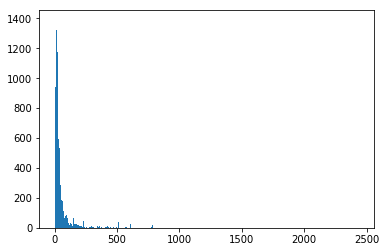

In [19]:
h = plt.hist(lengths, bins=500)

In [20]:
h[0]

array([ 1180.,   940.,  1384.,  1322.,  1174.,   722.,   592.,   536.,
         332.,   286.,   242.,   186.,   180.,   214.,   112.,   154.,
          68.,    82.,    58.,    88.,    70.,    64.,    32.,    30.,
          20.,    26.,    32.,    24.,    58.,    14.,    64.,     6.,
          28.,    16.,    24.,    28.,     8.,    18.,    14.,    18.,
          12.,    24.,    14.,    28.,    14.,     4.,    12.,    44.,
           4.,     6.,     2.,     4.,     6.,     0.,    36.,     0.,
           4.,     4.,     8.,     6.,    14.,     8.,     8.,     8.,
           2.,     0.,     6.,     2.,     2.,     4.,    12.,    14.,
           8.,    12.,     6.,     0.,     4.,     4.,     2.,     0.,
           2.,     0.,     4.,     6.,     0.,     4.,    14.,    26.,
           4.,     0.,     2.,     4.,     4.,     2.,     4.,     2.,
           6.,     0.,     2.,     2.,     2.,     6.,     4.,     2.,
          40.,     4.,     0.,     0.,     2.,     0.,     0.,     0.,
      

In [21]:
h[1]

array([    0.   ,     4.878,     9.756,    14.634,    19.512,    24.39 ,
          29.268,    34.146,    39.024,    43.902,    48.78 ,    53.658,
          58.536,    63.414,    68.292,    73.17 ,    78.048,    82.926,
          87.804,    92.682,    97.56 ,   102.438,   107.316,   112.194,
         117.072,   121.95 ,   126.828,   131.706,   136.584,   141.462,
         146.34 ,   151.218,   156.096,   160.974,   165.852,   170.73 ,
         175.608,   180.486,   185.364,   190.242,   195.12 ,   199.998,
         204.876,   209.754,   214.632,   219.51 ,   224.388,   229.266,
         234.144,   239.022,   243.9  ,   248.778,   253.656,   258.534,
         263.412,   268.29 ,   273.168,   278.046,   282.924,   287.802,
         292.68 ,   297.558,   302.436,   307.314,   312.192,   317.07 ,
         321.948,   326.826,   331.704,   336.582,   341.46 ,   346.338,
         351.216,   356.094,   360.972,   365.85 ,   370.728,   375.606,
         380.484,   385.362,   390.24 ,   395.118, 

In [22]:
max_sent_len =  h[1][np.argmax(h[0])]
min_sent_len = h[1][1]
print('Most probable length = ', max_sent_len)
print('Count of most probable lenght = ', np.max(h[0]))
print('Min length = ', min_sent_len)

Most probable length =  9.756
Count of most probable lenght =  1384.0
Min length =  4.878


In [23]:
max_sent_len =  100#int(np.ceil(max_sent_len))
min_sent_len = 4#int(np.floor(min_sent_len))

In [24]:
print('Most probable length = ', max_sent_len)
print('Min length = ', min_sent_len)

Most probable length =  50
Min length =  4


In [25]:
num_samples = 1000000

tess_correction_data = os.path.join(data_path, 'all_ocr_data_2.txt')
input_texts_OCR_tess, target_texts_tess, gt_tess = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)

num_samples = 0
OCR_data = os.path.join(data_path, 'output_handwritten.txt')
input_texts_OCR_hand, target_texts_OCR_hand, gt_texts_OCR_hand = load_data_with_gt(OCR_data, num_samples, max_sent_len, min_sent_len, delimiter='|',gt_index=0, prediction_index=1)

In [26]:
#input_texts = input_texts_OCR
#target_texts = target_texts_OCR
input_texts_OCR = input_texts_OCR_tess + input_texts_OCR_hand
target_texts_OCR = target_texts_tess + target_texts_OCR_hand


In [27]:
len(input_texts_OCR)

3579

# Results of pre-training on generic data

In [28]:
'''
num_samples = 0
big_data = os.path.join(data_path, 'big.txt')
threshold = 0.9
input_texts_gen, target_texts_gen, gt_gen = load_data_with_noise(file_name=big_data, 
                                                                 num_samples=num_samples, 
                                                                 noise_threshold=threshold, 
                                                                 max_sent_len=max_sent_len, 
                                                                 min_sent_len=min_sent_len)
'''                                                                 

"\nnum_samples = 0\nbig_data = os.path.join(data_path, 'big.txt')\nthreshold = 0.9\ninput_texts_gen, target_texts_gen, gt_gen = load_data_with_noise(file_name=big_data, \n                                                                 num_samples=num_samples, \n                                                                 noise_threshold=threshold, \n                                                                 max_sent_len=max_sent_len, \n                                                                 min_sent_len=min_sent_len)\n"

In [29]:
#input_texts = input_texs_gen
#target_texts = target_texts_gen

# Results on noisy tesseract corrections

In [30]:
num_samples = 10000
tess_correction_data = os.path.join(data_path, 'all_ocr_data_2.txt')
threshold = 0.9
input_texts_noisy_OCR, target_texts_noisy_OCR, gt_noisy_OCR = load_data_with_noise(file_name=tess_correction_data, 
                                                                 num_samples=num_samples, 
                                                                 noise_threshold=threshold, 
                                                                 max_sent_len=max_sent_len, 
                                                                 min_sent_len=min_sent_len)

In [31]:
'''
input_texts = input_texts_noisy_OCR
target_texts = target_texts_noisy_OCR
'''

'\ninput_texts = input_texts_noisy_OCR\ntarget_texts = target_texts_noisy_OCR\n'

# Results on merge of tesseract correction + generic data

In [32]:
'''
input_texts = input_texts_OCR + input_texts_gen
target_texts = input_texts_OCR + target_texts_gen
'''

'\ninput_texts = input_texts_OCR + input_texts_gen\ntarget_texts = input_texts_OCR + target_texts_gen\n'

# Results noisy tesseract correction + generic data

In [33]:
'''
input_texts = input_texts_noisy_OCR + input_texts_gen
target_texts = input_texts_noisy_OCR + target_texts_gen
'''

'\ninput_texts = input_texts_noisy_OCR + input_texts_gen\ntarget_texts = input_texts_noisy_OCR + target_texts_gen\n'

# Results noisy tesseract noisy + correction data

In [34]:
input_texts = input_texts_noisy_OCR + input_texts_OCR
target_texts = target_texts_noisy_OCR + target_texts_OCR

# Results of pre-training on generic and fine tuning on tesseract correction

In [35]:
# TODO

In [36]:
# Sample data
print(len(input_texts))
for i in range(10):
    print(input_texts[i], '\n', target_texts[i])

13579
Claim Tpye:n VB Accident - Acicdental Injury 
 	Claim Type: VB Accident - Accidental Injury


Policyohlder/OwnrI nformation 
 	Policyholder/Owner Information


First Nme: 
 	First Name:


MiddleN ame/Iintial: 
 	Middle Name/Initial:


kLast Name: 
 	Last Name:


Sdociqal Security Numrber: 
 	Social Security Number:


Birth Date: 
 	Birth Date:


Gender: 
 	Gender:


Langag ePreference:h 
 	Language Preference:


Address Line 1: 
 	Address Line 1:




## Build vocab

In [37]:
all_texts = target_texts + input_texts
vocab_to_int, int_to_vocab = build_vocab(all_texts)
np.savez('vocab', vocab_to_int=vocab_to_int, int_to_vocab=int_to_vocab, max_sent_len=max_sent_len, min_sent_len=min_sent_len )

In [38]:
input_characters = sorted(list(vocab_to_int))
target_characters = sorted(list(vocab_to_int))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [39]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 13579
Number of unique input tokens: 115
Number of unique output tokens: 115
Max sequence length for inputs: 49
Max sequence length for outputs: 49


In [40]:
vocab_to_int # Some special chars need to be removed TODO: Data cleaning

{'\t': 2,
 '\n': 3,
 ' ': 1,
 '!': 104,
 '"': 95,
 '#': 67,
 '$': 80,
 '%': 85,
 '&': 73,
 "'": 83,
 '(': 63,
 ')': 64,
 '*': 77,
 '+': 76,
 ',': 69,
 '-': 21,
 '.': 48,
 '/': 29,
 '0': 54,
 '1': 43,
 '2': 53,
 '3': 57,
 '4': 66,
 '5': 74,
 '6': 55,
 '7': 70,
 '8': 60,
 '9': 72,
 ':': 13,
 ';': 75,
 '<': 107,
 '=': 94,
 '?': 59,
 '@': 81,
 'A': 16,
 'B': 15,
 'C': 4,
 'D': 40,
 'E': 45,
 'F': 33,
 'G': 41,
 'H': 52,
 'I': 22,
 'J': 68,
 'K': 50,
 'L': 37,
 'M': 36,
 'N': 35,
 'O': 30,
 'P': 26,
 'Q': 78,
 'R': 46,
 'S': 38,
 'T': 9,
 'U': 49,
 'UNK': 0,
 'V': 14,
 'W': 51,
 'X': 79,
 'Y': 47,
 'Z': 71,
 '[': 91,
 '\\': 97,
 ']': 92,
 '^': 86,
 '_': 105,
 'a': 6,
 'b': 39,
 'c': 17,
 'd': 18,
 'e': 12,
 'f': 32,
 'g': 42,
 'h': 28,
 'i': 7,
 'j': 23,
 'k': 58,
 'l': 5,
 'm': 8,
 'n': 19,
 'o': 27,
 'p': 11,
 'q': 56,
 'r': 25,
 's': 34,
 't': 20,
 'u': 24,
 'v': 44,
 'w': 31,
 'x': 61,
 'y': 10,
 'z': 62,
 '{': 108,
 '|': 82,
 '}': 100,
 '~': 103,
 '£': 113,
 '§': 109,
 '«': 111,
 '®': 

In [41]:
int_to_vocab

{0: 'UNK',
 1: ' ',
 2: '\t',
 3: '\n',
 4: 'C',
 5: 'l',
 6: 'a',
 7: 'i',
 8: 'm',
 9: 'T',
 10: 'y',
 11: 'p',
 12: 'e',
 13: ':',
 14: 'V',
 15: 'B',
 16: 'A',
 17: 'c',
 18: 'd',
 19: 'n',
 20: 't',
 21: '-',
 22: 'I',
 23: 'j',
 24: 'u',
 25: 'r',
 26: 'P',
 27: 'o',
 28: 'h',
 29: '/',
 30: 'O',
 31: 'w',
 32: 'f',
 33: 'F',
 34: 's',
 35: 'N',
 36: 'M',
 37: 'L',
 38: 'S',
 39: 'b',
 40: 'D',
 41: 'G',
 42: 'g',
 43: '1',
 44: 'v',
 45: 'E',
 46: 'R',
 47: 'Y',
 48: '.',
 49: 'U',
 50: 'K',
 51: 'W',
 52: 'H',
 53: '2',
 54: '0',
 55: '6',
 56: 'q',
 57: '3',
 58: 'k',
 59: '?',
 60: '8',
 61: 'x',
 62: 'z',
 63: '(',
 64: ')',
 65: '’',
 66: '4',
 67: '#',
 68: 'J',
 69: ',',
 70: '7',
 71: 'Z',
 72: '9',
 73: '&',
 74: '5',
 75: ';',
 76: '+',
 77: '*',
 78: 'Q',
 79: 'X',
 80: '$',
 81: '@',
 82: '|',
 83: "'",
 84: '•',
 85: '%',
 86: '^',
 87: '●',
 88: 'ﬁ',
 89: '”',
 90: '°',
 91: '[',
 92: ']',
 93: '–',
 94: '=',
 95: '"',
 96: '✓',
 97: '\\',
 98: 'ﬂ',
 99: '‘',
 100:

In [42]:
len(int_to_vocab)

115

# Prepare training data

## Train/test split

In [43]:
# Split the data into training and testing sentences
input_texts, test_input_texts, target_texts, test_target_texts  = train_test_split(input_texts, target_texts, test_size = 0.15, random_state = 42)

## Vectorize data

## Train data

In [44]:
encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

In [45]:
print(encoder_input_data.shape)
print(decoder_target_data.shape)

(11542, 49)
(11542, 49, 115)


## Test data

In [46]:
test_encoder_input_data, test_decoder_input_data, test_decoder_target_data = vectorize_data(input_texts=test_input_texts,
                                                                                            target_texts=test_target_texts, 
                                                                                            max_encoder_seq_length=max_encoder_seq_length, 
                                                                                            num_encoder_tokens=num_encoder_tokens, 
                                                                                            vocab_to_int=vocab_to_int)

# Encoder-decoder model

In [47]:

latent_dim = 256  # Latent dimensionality of the encoding space.

In [48]:
model, encoder_model, decoder_model = build_model(latent_dim=latent_dim, num_encoder_tokens=num_encoder_tokens)

[<tf.Tensor 'concatenate_1/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(?, 512) dtype=float32>]
Tensor("lstm_2/transpose_2:0", shape=(?, ?, 512), dtype=float32)
Tensor("bidirectional_1/concat:0", shape=(?, ?, 512), dtype=float32)
encoder-decoder  model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 115)    13225       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
______________

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


# Training

In [49]:
batch_size = 64  # Batch size for training.
epochs = 50  
lr = 0.01

# Learning rate decay

In [50]:
model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [51]:
#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_model.hdf5" # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]



In [52]:
def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate
lrate = LearningRateScheduler(exp_decay)
#lr = 0

In [53]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)
#lr = 0

In [54]:
#callbacks_list.append(lrate)

In [55]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          #validation_split=0.2,
          shuffle=True)

Train on 11542 samples, validate on 2037 samples
Epoch 1/50
11542/11542 [==============================] - 66s 6ms/step - loss: 2.2220 - categorical_accuracy: 0.3935 - val_loss: 0.7520 - val_categorical_accuracy: 0.7641

Epoch 00001: val_categorical_accuracy improved from -inf to 0.76414, saving model to best_model.hdf5


/opt/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_1/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/50
11542/11542 [==============================] - 64s 6ms/step - loss: 0.3843 - categorical_accuracy: 0.8609 - val_loss: 0.2919 - val_categorical_accuracy: 0.8851

Epoch 00002: val_categorical_accuracy improved from 0.76414 to 0.88510, saving model to best_model.hdf5
Epoch 3/50
11542/11542 [==============================] - 65s 6ms/step - loss: 0.2051 - categorical_accuracy: 0.9065 - val_loss: 0.2271 - val_categorical_accuracy: 0.9002

Epoch 00003: val_categorical_accuracy improved from 0.88510 to 0.90016, saving model to best_model.hdf5
Epoch 4/50
11542/11542 [==============================] - 64s 6ms/step - loss: 0.1374 - categorical_accuracy: 0.9226 - val_loss: 0.1992 - val_categorical_accuracy: 0.9070

Epoch 00004: val_categorical_accuracy improved from 0.90016 to 0.90703, saving model to best_model.hdf5
Epoch 5/50
11542/11542 [==============================] - 64s 6ms/step - loss: 0.1018 - categorical_accuracy: 0.9309 - val_loss: 0.1923 - val_categorical_accuracy: 0.9095



KeyboardInterrupt: 

In [ ]:
encoder_model.save('encoder_model.hdf5')
decoder_model.save('decoder_model.hdf5')

In [ ]:
#encoder_input_data[1:2][0]

In [ ]:
#vocab_to_int

In [ ]:
#decode_gt_sequence(encoder_input_data[5:6], int_to_vocab)

In [56]:
# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_seq = np.argmax(decoder_target_data[seq_index: seq_index + 1], axis=-1)
    #print(target_seq)
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

[[30 46  9 52 30 26 45 40 22  4 38  3  3  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]]
-
Input sentence: OTRHOPEDICS
GT sentence: ORTHOPEDICS

Decoded sentence: ORTHOPEDICS

[[49  4 46 29 35 27 19 21 26  6 25  1 16 18 23 24 34 20  8 12 19 20  3  3
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]]
-
Input sentence: UCR/nNo-nPar kAdjusten
GT sentence: UCR/Non-Par Adjustment

Decoded sentence: UCR/Non-Par Adjustment

[[16  4  4 22 40 45 35  9  1  4 37 16 22 36  1 33 30 46 36  3  3  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]]
-
Input sentence: ACCIDENT CLIAM FOR

GT sentence: ACCIDENT CLAIM FORM

Decoded sentence: ACCIDENT CLAIM FORM

[[36 12 18  7 17  6  5  1 26 25 27 44  7 18 12 25  1 22 19 32 27 25  8  6
  20  7 27 19  1 21  1 26 28 10 34  7 17  7  6 19  3  3  0  0  0  0  0  0
   0]]
-
Input sentence: Medial Providier Iformation - Physiican
GT s

-
Input sentence: Patrzicipan taNme:
GT sentence: Participant Name:

Decoded sentence: Participant Name:

[[41 49 16 46 16 35  9 30 46  1 22 40  3  3  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]]
-
Input sentence: GUARNTOR ID
GT sentence: GUARANTOR ID

Decoded sentence: GUARANTOR ID

[[19 27 19  9  9 26  1  6  5 27 19 42  1 20 28 12  1  8 12 18  7  6  5  1
  23 27  7 19 20  1  5  7 19 12 48  3  3  0  0  0  0  0  0  0  0  0  0  0
   0]]
-
Input sentence: nbonTTP along bthe medial joit line.
GT sentence: nonTTP along the medial joint line.

Decoded sentence: nonTTP along the medial joint line.

[[ 4 30 36 36 45 46  4 22 16 37  1 26 16 47 36 45 35  9  3  3  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]]
-
Input sentence: COMMERCIL PAENTb
GT sentence: COMMERCIAL PAYMENT

Decoded sentence: COMMERCILI PAYMENT

[[16 34 34 12 34 34  8 12 19 20 29 26  5  6 19 13  3  3  0  0  0  0  0  0


-
Input sentence: Physciian’s Tax ID Number:
GT sentence: Physician’s Tax ID Number:

Decoded sentence: Physician’s Tax ID Number:

[[30 20 28 12 25  3  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]]
-
Input sentence: Otehr
GT sentence: Other

Decoded sentence: Other

[[28 27 24 25 34 29 31 12 12 58  3  3  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]]
-
Input sentence: hoursp/week
GT sentence: hours/week

Decoded sentence: hours week

[[51 12 39 34  7 20 12 13  1  8 10 33  7 25 34 20  4 28 27  7 17 12 48 32
  17 28 19 48 17 27  8  3  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]]
-
Input sentence: Wnbsite: myFirtChoice.fchn.com
GT sentence: Website: myFirstChoice.fchn.com

Decoded sentence: Website: myFirstChoice.fchn.com

[[40 12 42 25 12 12  3  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0 

In [ ]:
#WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
#print('WER_spell_correction |TRAIN= ', WER_spell_correction)

In [57]:
# Sample output from test data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(len(test_input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = test_encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = test_target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', test_input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

-
Input sentence: Chloice
GT sentence: Choice:

Decoded sentence: Choice

-
Input sentence: Patijent Date of Birth(mm/dd/yy)
GT sentence: Patient Date of Birth (mm/dd/yy)

Decoded sentence: Patient Date of Birth (mm/dd/yy)

-
Input sentence: PATIENT BALANC
GT sentence: PATIENT BALANCE

Decoded sentence: PATIENT BALANC

-
Input sentence: Souse On & Off-bJobA cc April 1, 2017
GT sentence: Spouse On & Off-Job Acc April 1, 2017

Decoded sentence: Spouse On & Off-Job Acc April 1, 2017

-
Input sentence: Pﬁnreo Name _ ocia ecuri y um er
GT sentence: Printed Name Social Security Number

Decoded sentence: Performe Name of Scrial y mber

-
Input sentence: Providen'Facility: ProMedicn Tole do Hospital
GT sentence: Provider/Facility: ProMedica Toledo Hospital

Decoded sentence: Provider Facility: ProMedic  Toledo Hospital

-
Input sentence: Down East Orthxopedicws Sbports Mkeidcinwe 
GT sentence: Down East Orthopedics Sports Medicine 

Decoded sentence: Down East Orthopedics Sports Medicine 

-
I

-
Input sentence: Electronically Signed Indicator: Yes
GT sentence: Electronically Signed Indicator:  Yes

Decoded sentence: Electronically Signed Indicator: Yes

-
Input sentence: Forwarding Service Requested
GT sentence: Forwarding Service Requested

Decoded sentence: Forwarding Service Requested

-
Input sentence: Dat Signed
GT sentence: Date Signed

Decoded sentence: Date Signed

-
Input sentence: Revsed
GT sentence: Revised

Decoded sentence: Reved

-
Input sentence: Customer Policy #:
GT sentence: Customer Policy #:

Decoded sentence: Customer Policy #:

-
Input sentence: CLINICAL HISTORY:
GT sentence: CLINICAL HISTORY:

Decoded sentence: CLINICAL HISTORY:

-
Input sentence: COMPARISOhN: oNn.
GT sentence: COMPARISON: None.

Decoded sentence: COMPARISON: No.

-
Input sentence: Total Monthly Premium:
GT sentence: Total Monthly Premium:

Decoded sentence: Total Monthly Premium:

-
Input sentence: City State Zip
GT sentence: City State Zip

Decoded sentence: City State Zip

-
Input s

Input sentence: Rad ExamF niger(s) Mini 2 Veiwsq
GT sentence: Rad Exam Finger(s) Mini 2 Views

Decoded sentence: Rad Exam  arnisy Mini 2 Vins

-
Input sentence: DETAILS OF SEyRVICE
GT sentence: DETAILS OF SERVICES

Decoded sentence: DETAILS OF SERVICE

-
Input sentence: ENCOUNTER FOR WlTH
GT sentence: ENCOUNTER FOR WITH

Decoded sentence: ENCOUNTER FOR WITH

-
Input sentence: Printe Name Scoial Securty Numbe
GT sentence: Printed Name Social Security Number

Decoded sentence: Printed Name Social Security Number

-
Input sentence: ReachA bove Left Shoulder
GT sentence: Reach Above Left Shoulder

Decoded sentence: Reach Above Left Shoulder

-
Input sentence: Work State/Country:
GT sentence: Work State/Country:

Decoded sentence: Work State/Country:

-
Input sentence: City:
GT sentence: City:

Decoded sentence: City:

-
Input sentence: BMI: 20.73
GT sentence: BMI: 20.73

Decoded sentence: BMI: 20.73

-
Input sentence: Active: Reviewed Alleriges; Penicillins - Rash
GT sentence: Active: Revi

-
Input sentence: Pratigent MRN:
GT sentence: Patient MRN:

Decoded sentence: Pratient MRN:

-
Input sentence: Ttoal Mnothtly Ppremuim:
GT sentence: Total Monthly Premium:

Decoded sentence: Total Monthly Premium:

-
Input sentence: uSrgery Date:
GT sentence: Surgery Date:

Decoded sentence: Surgery Date:

-
Input sentence: Hnomei Email -h
GT sentence: Home Email -

Decoded sentence: Homemin mail -

-
Input sentence: Provier Last Nae :Hkaimf
GT sentence: Provider Last Name: Hakim

Decoded sentence: Provider Last Name: Holm

-
Input sentence: Irmatienthutpatient Indicator: Outpatient
GT sentence: Inpatient/Outpatient Indicator: Outpatient

Decoded sentence: Inditienthutatient Indicator: Outpatient

-
Input sentence: Propuct: Long Ter Disabiilty
GT sentence: Product: Long Term Disability

Decoded sentence: Propuct: Long Term Disability

-
Input sentence: Cmsmr Sweetnfomatwni
GT sentence: Customer Service Information

Decoded sentence: Custome Semtnomation

-
Input sentence: Website: myFi

-
Input sentence: Preferred language is English.
GT sentence: Preferred language is English.

Decoded sentence: Preferred language is English.

-
Input sentence: Home per day
GT sentence: Hours per day

Decoded sentence: Home per day

-
Input sentence: l:lShUiL Term Disability
GT sentence: Short Term Disability

Decoded sentence: Sicisiser Term Disability

-
Input sentence: Service Date:
GT sentence: Services Date:

Decoded sentence: Service Date:

-
Input sentence: Thrapy: 21Jna2108 to Recred
GT sentence: Therapy: 21Jan2018 to Recorded

Decoded sentence: Thrapy: 21Jan2 18 to Recred

-
Input sentence: HEIGHT
GT sentence: HEIGHT

Decoded sentence: HEIGHT

-
Input sentence: Not Covered Amount
GT sentence: Not Covered Amount

Decoded sentence: Not Covered Amount

-
Input sentence: Work Telephone wNumber
GT sentence: Work Telephone Number

Decoded sentence: Work Telephone Number

-
Input sentence: NARRATIVES ATTACHED? D YES D No
GT sentence: NARRATIVES ATTACHED? YES NO

Decoded sentence: N

-
Input sentence: Expected Delivery Date: (mmlddlyy) 
GT sentence: Expected Delivery Date: (mm/dd/yy)

Decoded sentence: Expected Delivery Date: (mm/dd/yy) 

-
Input sentence: . Appeals Rights
GT sentence: Appeals Rights

Decoded sentence: Appeals Rights

-
Input sentence: Lats Nsame:
GT sentence: Last Name:

Decoded sentence: Last Name:

-
Input sentence: Electromcally Signed Indicator: Yes
GT sentence: Electronically Signed Indicator: Yes

Decoded sentence: Electronically Signed Indicator: Yes

-
Input sentence: Social Security Nume:
GT sentence: Social Security Number:

Decoded sentence: Social Security Number:

-
Input sentence: Soial Security Number
GT sentence: Social Security Number

Decoded sentence: Social Security Number

-
Input sentence: TWI CIITES ORTHOPEDICS
GT sentence: TWIN CITIES ORTHOPEDICS

Decoded sentence: TWIN CITIES ORTHOPEDICS

-
Input sentence: Citry:
GT sentence: City:

Decoded sentence: City:

-
Input sentence: Hours per day 
GT sentence: Hours per day 

Deco

-
Input sentence: DIAGNOSIS CODE
GT sentence: DIAGNOSIS CODE

Decoded sentence: DIAGNOSIS CODE

-
Input sentence: Cnofirmation f Coverage
GT sentence: Confirmation of Coverage

Decoded sentence: Coveration of Coverage

-
Input sentence: Last Name:
GT sentence: Last Name:

Decoded sentence: Last Name:

-
Input sentence: Acdient Date:
GT sentence: Accident Date:

Decoded sentence: Accident Date:

-
Input sentence: 15 SIII‘HED" Required:
GT sentence: Is Surgery Required: Unknown

Decoded sentence: InS5rICE PRInitired:

-
Input sentence: City:
GT sentence: City:

Decoded sentence: City:

-
Input sentence: TEMPERmTURE/PULSlE/RESPzIRATION
GT sentence: TEMPERATURE/PULSE/RESPIRATION

Decoded sentence: TEMPERTHE/PULSE/PLUSE/RESPRIRATION

-
Input sentence: TWIN CITIES ROHOPEDICS
GT sentence: TWIN CITIES ORTHOPEDICS

Decoded sentence: TWIN CITIES ROMPEDICS

-
Input sentence: Gender:
GT sentence: Gender:

Decoded sentence: Gender:

-
Input sentence: ePRACTITIONER'S REPORT
GT sentence: PRACTITIONER

-
Input sentence: qToay’s Date Retur nto Prevyioeus Work ?Yes No
GT sentence: Today’s Date Return to Previous Work? Yes No

Decoded sentence: Today’s Date Returs Work tork? Yes Work?: Work: No
-
Input sentence: D Thopmsn McGuire ,MD
GT sentence: D Thompson McGuire, MD

Decoded sentence: D Thomps Mesnite MD

-
Input sentence: EMPcLOYER NAME
GT sentence: EMPLOYER NAME

Decoded sentence: EMPLOYER NAME

-
Input sentence: 3) Zithromax (azithromycin) (moderate)
GT sentence: 3) Zithromax (azithromycin) (moderate)

Decoded sentence: 3) Zithromax (azithromycin) (moderate)

-
Input sentence: Member No:
GT sentence: Member No:

Decoded sentence: Member No:

-
Input sentence: gThe Benefits Center
GT sentence: The Benefits Center

Decoded sentence: The Benefits Center

-
Input sentence: Summary 0% Today's Visit
GT sentence: Summary Of Today’s Visit

Decoded sentence: Summary of Today's Visit

-
Input sentence: Social Security Nubmer
GT sentence: Social Security Number

Decoded sentence: Social Secu

-
Input sentence: ACCIDENa CLAIM FORM
GT sentence: ACCIDENT CLAIM FORM

Decoded sentence: ACCIDENT CLAIM FORM

-
Input sentence: Never
GT sentence: Never

Decoded sentence: Never

-
Input sentence: Employer Name:
GT sentence: Employer Name:

Decoded sentence: Employer Name:

-
Input sentence: DueD at
GT sentence: Due Date

Decoded sentence: Due Date

-
Input sentence: CI Short Term Disabiiétv
GT sentence: Short Term Disability 

Decoded sentence: CISShort Term Disability

-
Input sentence: Home Addres
GT sentence: Home Address

Decoded sentence: Home Address

-
Input sentence: PAY THIS AMOUdNT $301.t48
GT sentence: PAY THIS AMOUNT $301.48

Decoded sentence: PAY THIS AMOUNT $301.48

-
Input sentence: Medical Prvide rRoes: Treainmg
GT sentence: Medical Provider Roles: Treating

Decoded sentence: Medical Provider Roles: Treating

-
Input sentence: DPEHATIVEIPHOCEDUFIE NOTE
GT sentence: OPERATIVE/PROCEDURE NOTE

Decoded sentence: DPERATIVE VIOCEDUREDUR NOTE

-
Input sentence: Middle Narmfl

-
Input sentence: nonTTP along the medial joint line.
GT sentence: nonTTP along the medial joint line.

Decoded sentence: nonTTP along the medial joint line.

-
Input sentence: Messag:
GT sentence: Message:

Decoded sentence: Message:

-
Input sentence: Location : WCiNYP - Starr
GT sentence: Location : WCINYP - Starr 

Decoded sentence: Location : WCINYP - Starr

-
Input sentence: Empleye On & Off-Jb Acc Apri , 2015
GT sentence: Employee On & Off-Job Acc April 1, 2015

Decoded sentence: Employee On & Off-Job Acc Aprit #

-
Input sentence: Electronically Signed 02/28/2018
GT sentence: Electronically Signed 02/28/2018

Decoded sentence: Electronically Signed 02/28/2018

-
Input sentence: DESCRIPTION OF SERVICE
GT sentence: DESCRIPTION OF SERVICE

Decoded sentence: DESCRIPTION OF SERVICE

-
Input sentence: Suegry - TBD
GT sentence: Surgery - TBD

Decoded sentence: Sergery - T BD

-
Input sentence: . i . ACCIDENT CLAIM FORM
GT sentence: ACCIDENT CLAIM FORM

Decoded sentence: C. INCIDENT CL

-
Input sentence: City Sate Zip
GT sentence: City Sate Zip

Decoded sentence: City State Zip

-
Input sentence: SEEN SH"?
GT sentence: SUN CITY

Decoded sentence: SEEN SHist ?

-
Input sentence: patient:
GT sentence: Patient :

Decoded sentence: patient:

-
Input sentence: ACCIDENT LCAM FOvRM
GT sentence: ACCIDENT CLAIM FORM

Decoded sentence: ACCIDENT CLAIM FORM

-
Input sentence: Last Name:
GT sentence: Last Name:

Decoded sentence: Last Name:

-
Input sentence: Address
GT sentence: Address

Decoded sentence: Address

-
Input sentence: Inusred/atient Spiggnatrue 
GT sentence: Insured/Patient Signature 

Decoded sentence: Insured/atient Spigiatrue 

-
Input sentence: MRN: DhOyB:
GT sentence: MRN: DOB:

Decoded sentence: MRN: DOB:

-
Input sentence: The Benefits Csenter
GT sentence: The Benefits Center

Decoded sentence: The Benefits Center

-
Input sentence: Page 3 of 3
GT sentence: Page 3 of 3

Decoded sentence: Page 3 of 3

-
Input sentence: 287891 0
GT sentence: Z87891 ?

Decoded s

-
Input sentence: At niwght
GT sentence: At night

Decoded sentence: At Infirmation

-
Input sentence: gHousrw orked updatyed : Yesg
GT sentence: Hours worked updated : Yes

Decoded sentence: Hour worked updatyed : Yesg

-
Input sentence: As neeed
GT sentence: As needed

Decoded sentence: As neeced

-
Input sentence: Eletornicaplly Sined Date:a
GT sentence: Electronically Signed Date:

Decoded sentence: Electronically Signed Date:

-
Input sentence: Part-time htours er day
GT sentence: Part-time hours per day

Decoded sentence: Part-ime thtors Cerday

-
Input sentence: Date of Birt (mm/dd/yy)
GT sentence: Date of Birth (mm/dd/yy)

Decoded sentence: Date of Birth (mm/dd/yy)

-
Input sentence: Autohr: Larkin, John J MD
GT sentence: Author: Larkin, John J MD

Decoded sentence: Authror: Larkin, John J MD

-
Input sentence: Seen Bdy: Vija yPatel,c MD
GT sentence: Seen By: Vijay Patel, MD

Decoded sentence: Seen By: Vijay Patell, MD

-
Input sentence: MASTERCARDb
GT sentence: MASTERCARD

Dec

-
Input sentence: Medicla Provider Specialty: Hsopita
GT sentence: Medical Provider Specialty: Hospital

Decoded sentence: Medical Provider Specialty: Hospital

-
Input sentence: Exam Date/Time
GT sentence: Exam Date/Time

Decoded sentence: Exam Date/Time

-
Input sentence: Revised
GT sentence: Revised

Decoded sentence: Revised

-
Input sentence: Fnorwarding Servc eRqustd
GT sentence: Forwarding Service Requested

Decoded sentence: Forwarding Service Services

-
Input sentence: CustmoerPolciy #h:
GT sentence: Customer Policy #:

Decoded sentence: Customer Policy #:

-
Input sentence: Date of hFitrst Visit:
GT sentence: Date of First Visit:

Decoded sentence: Date of First Visit:

-
Input sentence: Keybonld wulk .
GT sentence: Keyboard work

Decoded sentence: Keybound wulk .

-
Input sentence: Acceson XR-8-0020951
GT sentence: Accession XR-18-0020951

Decoded sentence: Accesson XR-0020920951

-
Input sentence: Customer Policy #:
GT sentence: Customer Policy #:

Decoded sentence: Custom

-
Input sentence: Ins: Mainecarse
GT sentence: Ins: Mainecare

Decoded sentence: Ins: Mainecare

-
Input sentence: Twist
GT sentence: Twist

Decoded sentence: wist

-
Input sentence: Past Medical History:
GT sentence: Past Medical History:

Decoded sentence: Past Medical History:

-
Input sentence: Date of Birth (mm/dd/yy)
GT sentence: Date of Birth (mm/dd/yy)

Decoded sentence: Date of Birth (mm/dd/yy)

-
Input sentence: Information written in other anguaes
GT sentence: Information written in other languages

Decoded sentence: Information written in other anguages

-
Input sentence: SECONDAR YINSUR:
GT sentence: SECONDARY INSUR:

Decoded sentence: SECONDAR INSUR:

-
Input sentence: nState/Province:
GT sentence: State/Province:

Decoded sentence: State/Province:

-
Input sentence: Customer Policy #:
GT sentence: Customer Policy #:

Decoded sentence: Customer Policy #:

-
Input sentence: Total Monthly Premium:
GT sentence: Total Monthly Premium:

Decoded sentence: Total Monthly Premium:

-
Input sentence: Accident Wrk bRelated: No
GT sentence: Accident Work Related: No

Decoded sentence: Accident Work Related: No

-
Input sentence: Siut 2 - Mental ealth
GT sentence: Suite 2 - Mental Health

Decoded sentence: Signat 2 - Mental eat

-
Input sentence: Does schedule vary? - yes
GT sentence: Does schedule vary? - yes

Decoded sentence: Does schedule vary? - yes

-
Input sentence: Contract Adiustrnent
GT sentence: Contract Adjustment

Decoded sentence: Contract Adjustment

-
Input sentence: SURGEONe: JASoON HOL,M M.D. 
GT sentence: SURGEON: JASON HOLM, M.D. 

Decoded sentence: SURGEON: JASON HOLM MD, MION S

-
Input sentence: Prkimayr Diagnosis:
GT sentence: Primary Diagnosis:

Decoded sentence: Primary Diagnosis:

-
Input sentence: Date of Birtqh (m/dd/yy)
GT sentence: Date of Birth (mm/dd/yy)

Decoded sentence: Date of Birth (mm/dd/yy)

-
Input sentence: Absenwce tart time -
GT sentence: Absence start time -

Decoded sentence: Absernce tart time -

-
Input sentence: State/

-
Input sentence: Employer:
GT sentence: Employer:

Decoded sentence: Employer:

-
Input sentence: _DJUSTMENTS
GT sentence: ADJUSTMENTS

Decoded sentence: UMSTMENTS

-
Input sentence: Current Medications:
GT sentence: Current Medications:

Decoded sentence: Current Medications:

-
Input sentence: Claim Event Ifnordmatsion
GT sentence: Claim Event Information

Decoded sentence: Claim Event Information

-
Input sentence: Visit Dtae:
GT sentence: Visit Date:

Decoded sentence: Visit Date:

-
Input sentence: ufn xuposre: occasionally
GT sentence: Sun Exposure: occasionally

Decoded sentence: of Suppore: occasionally

-
Input sentence: ● Yuop pian becomes more sveerey.
GT sentence: ● You pain becomes more severe.

Decoded sentence: ● You pain becomes more severem

-
Input sentence: Qugalifie dsign langurag interpreters
GT sentence: Qualified sign language interpreters

Decoded sentence: Qualifie sign lang anterag interpreters

-
Input sentence: Signatuare Date
GT sentence: Signature Date

D

-
Input sentence: Cihild On & Off-JobAcc Fiebruary1, 2016
GT sentence: Child On & Off-Job Acc February 1, 2016

Decoded sentence: Child On & Off-Job Acc Fiebruary, 2016

-
Input sentence: Full Time Prt Time
GT sentence: Full Time Part Time

Decoded sentence: Full Time Prop Time

-
Input sentence: EympolyeN ame:
GT sentence: Employer Name:

Decoded sentence: Employee Name:

-
Input sentence: Timeo fh Accident:
GT sentence: Time of Accident:

Decoded sentence: Time of Accident:

-
Input sentence: Page:1  o f6
GT sentence: Page: 1 of 6

Decoded sentence: Page:1 of 6

-
Input sentence: Physician Siganture Date
GT sentence: Physician Signature Date

Decoded sentence: Physician Signature Date

-
Input sentence: Electronically Signed Indicator: Yes
GT sentence: Electronically Signed Indicator: Yes

Decoded sentence: Electronically Signed Indicator: Yes

-
Input sentence: Customer #:
GT sentence: Customer #:

Decoded sentence: Customer #:

-
Input sentence: Myi Spouse: 
GT sentence: My Spouse:

-
Input sentence: rmary Diagnosis:
GT sentence: Primary Diagnosis:

Decoded sentence: Print Diagnosis:

-
Input sentence: Cixtuy

GT sentence: City:

Decoded sentence: City:

-
Input sentence: Report rGoup :2j6
GT sentence: Report Group: 26

Decoded sentence: Report reGuprip:

-
Input sentence: Ify es as of what date? (mm/dd/y)y
GT sentence: If yes as of what date? (mm/dd/yy)

Decoded sentence: If yes as of what date? (mm/dd/yy)

-
Input sentence: Summary of Todaby’s Visit
GT sentence: Summary of Today’s Visit

Decoded sentence: Summary of Today’s Visit

-
Input sentence: Contry:
GT sentence: Country:

Decoded sentence: Country:

-
Input sentence: Officew Visit:P ostO p R tknee
GT sentence: Office Visit: Post Op Rt knee

Decoded sentence: Office Visit: Posto p ont- p thee

-
Input sentence: Reviewed history fhrom anqd onb chagnes required:
GT sentence: Reviewed history from and no changes required:

Decoded sentence: Reviewed history from and on changes required:

-
Input sentence: Ele

-
Input sentence: cHas the ptet been hospitlaizfed? Yes No
GT sentence: Has the patient been hospitalized? Yes No

Decoded sentence: Has the the pet been hospitalized? Yes No

-
Input sentence: Location: rk nee
GT sentence: Location: r knee

Decoded sentence: Location: rk nees

-
Input sentence: None availale.
GT sentence: None available.

Decoded sentence: None availalle

-
Input sentence: AOUN:T 
GT sentence: AMOUNT: 

Decoded sentence: ATOUN: T

-
Input sentence: Ot-ofNetwork
GT sentence: Out-of-Network

Decoded sentence: Ot-of-Network

-
Input sentence: Last Name:b
GT sentence: Last Name:

Decoded sentence: Last Name:

-
Input sentence: cAcount No:
GT sentence: Account No:

Decoded sentence: Account No:

-
Input sentence: Fax Number 
GT sentence: Fax Number 

Decoded sentence: Fax Number 

-
Input sentence: Diadgnoiss:k ICD Cod:ed
GT sentence: Diagnosis: ICD Code:

Decoded sentence: Didanisis: ICD Code:

-
Input sentence: D. Information About Your Condition
GT sentence: D. Informat

-
Input sentence: Total nMontly Premium:
GT sentence: Total Monthly Premium:

Decoded sentence: Total na nemInd Premium:

-
Input sentence: Postal Cod:
GT sentence: Postal Code:

Decoded sentence: Postal Code:

-
Input sentence: Address
GT sentence: Address

Decoded sentence: Address

-
Input sentence: City:
GT sentence: City:

Decoded sentence: City:

-
Input sentence: PERFORM INFORMATION: Caubdell,z Ssuannah, RN
GT sentence: PERFORM INFORMATION: Caudell, Susannah, RN

Decoded sentence: PERFORM INFORMATION: Caudell, Susannah, RN

-
Input sentence: Rom/Bed EDGSCC/EDaGSC
GT sentence: Room/Bed EDGSCC/EDGSCC

Decoded sentence: Romer BEDGSCh/EDGSCODEDGSC

-
Input sentence: Gruop No:
GT sentence: Group No:

Decoded sentence: Group No:

-
Input sentence: Retain iFor Tax Purpose
GT sentence: Retain For Tax Purposes

Decoded sentence: Retain For Tax Purpose

-
Input sentence: MRf OhF THE LEFT WRIST IWTHOU CONTRASTd:
GT sentence: MRI OF THE LEFT WRIST WITHOUT CONTRAST:

Decoded sentence: MRI OF

-
Input sentence: Employer Name:
GT sentence: Employer Name:

Decoded sentence: Employer Name:

-
Input sentence: Emplwoyee home phone
GT sentence: Employee home phone

Decoded sentence: Employee home phone

-
Input sentence: OP Notes
GT sentence: OP Notes

Decoded sentence: OP Notes

-
Input sentence: Co- Ins—urges i
GT sentence: Co-Insurance

Decoded sentence: Co-Insurgurges in

-
Input sentence: Proedure ode 
GT sentence: Procedure Code 

Decoded sentence: Procedure of Service 

-
Input sentence: 07/32
GT sentence: 07/32

Decoded sentence: 07/32

-
Input sentence: PHONE:
GT sentence: PHONE:

Decoded sentence: PHONE:

-
Input sentence: SUqRGEON: John J. Larkin, M.D.
GT sentence: SURGEON: John J. Larkin, M.D.

Decoded sentence: SURGEON: John J. Larkin, M.D.

-
Input sentence: iTme of Aclcident:
GT sentence: Time of Accident:

Decoded sentence: Time of Accident:

-
Input sentence: Electronically Signed
GT sentence: Electronically Signed

Decoded sentence: Electronically Signed

-
Input

-
Input sentence: F/O Payqor/Pla
GT sentence: F/O Payor/Plan

Decoded sentence: F/O Paymer/Plan

-
Input sentence: JREEcMYS TATTNO 770-4601900
GT sentence: JEREMY STATTON 770-460-1900

Decoded sentence: RREEMENT TATION 770-460-N

-
Input sentence: Product:
GT sentence: Product:

Decoded sentence: Product:

-
Input sentence: Address
GT sentence: Address

Decoded sentence: Address

-
Input sentence: Comparison :
GT sentence: Comparison:

Decoded sentence: Comparison :

-
Input sentence: Indiviiduarl Summary
GT sentence: Individual Summary

Decoded sentence: Individuar Summary

-
Input sentence: Other Medical Conditions (Proleme Lit)
GT sentence: Other Medical Conditions (Problem List)

Decoded sentence: Other Medical Conditions (Proleme List)

-
Input sentence: OROcM: WW
GT sentence: ROOM: WW

Decoded sentence: OROcM: WW

-
Input sentence: Spouse 0n 8!. Off-Job Acc July 1, 2017'
GT sentence: Spouse On & Off-Job Acc July 1, 2017

Decoded sentence: Spouse On & Off-Job Acc July 1, 2017

-
I

-
Input sentence: Hours ‘Worked on Last Day: 8
GT sentence: Hours Worked on Last Day: 8

Decoded sentence: Hours Worked on Last Day: 8

-
Input sentence: uPatient Namae:
GT sentence: Patient Name:

Decoded sentence: Patient Name:

-
Input sentence: Address Line 1:
GT sentence: Address Line 1:

Decoded sentence: Address Line 1:

-
Input sentence: Business Telephone:
GT sentence: Business Telephone:

Decoded sentence: Business Telephone:

-
Input sentence: Physician’s Tax ID Number:
GT sentence: Physician’s Tax ID Number:

Decoded sentence: Physician’s Tax ID Number:

-
Input sentence: CC: rigwt ktnee pain.
GT sentence: CC: right knee pain.

Decoded sentence: CC: rigwt knee pain.

-
Input sentence: capsule 20 mg–  1 cap(s) ,Oral, Daliy
GT sentence: capsule 20 mg – 1 cap(s), Oral, Daily

Decoded sentence: capsule 20 mm & 1 cap(s), Oral, Daily

-
Input sentence: Clinical Summary Report
GT sentence: Clinical Summary Report

Decoded sentence: Clinical Summary Report

-
Input sentence: Fiexio

-
Input sentence: If yes,on what date (mm/dd/yy)?
GT sentence: If yes, on what date (mm/dd/yy)?

Decoded sentence: If yes, on what date (mm/dd/yy)?

-
Input sentence: wbww.unumb.co
GT sentence: www.unum.com

Decoded sentence: www.ununumb.com

-
Input sentence: bIce Heat Elevate Cruucthe
GT sentence: Ice Heat Elevate Crutches

Decoded sentence: Pice Health Evacted Couth

-
Input sentence: patella tendoniti

GT sentence: patella tendonitis

Decoded sentence: patella tendonitibs:

-
Input sentence: If yes, please prvoide the following:
GT sentence: If yes, please provide the following:

Decoded sentence: If yes, please provide the following:

-
Input sentence: U "um“ -
GT sentence: unum

Decoded sentence: Unum -

-
Input sentence: Plan Ernkings:
GT sentence: Plan Earnings:

Decoded sentence: Plan Earnings:

-
Input sentence: Secondary ICD code -
GT sentence: Secondary ICD code -

Decoded sentence: Secondary ICD code -

-
Input sentence: SURGEON: John J. Larkin, M.D.
GT sentence: SURGEON: 

-
Input sentence: City:
GT sentence: City:

Decoded sentence: City:

-
Input sentence: Original Print Date:
GT sentence: Original Print Date:

Decoded sentence: Original Print Date:

-
Input sentence: EE Name:
GT sentence: EE Name:

Decoded sentence: EE Name:

-
Input sentence: Country.
GT sentence: Country:

Decoded sentence: Country:

-
Input sentence: ATINT'S NAqME
GT sentence: PATIENT'S NAME

Decoded sentence: ATINT'S NAME

-
Input sentence: Kevin Finley DO
GT sentence: Kevin Finley DO

Decoded sentence: Kevin Finley DO

-
Input sentence: FAYETI'EVILLE . printed
GT sentence: FAYETTEVILLE printed

Decoded sentence: FAYETTEVILLE Orted?

-
Input sentence: Location : WCINYP - Starr

GT sentence: Location : WCINYP - Starr 

Decoded sentence: Location : WCINYP - Starr?

-
Input sentence: Plan Earnings:
GT sentence: Plan Earnings:

Decoded sentence: Plan Earnings:

-
Input sentence: Denies vaircose veins adn obn deformity.
GT sentence: Denies varicose veins and bone deformity.

Decoded se

-
Input sentence: Language Preference ﬂ English Elm Spanish
GT sentence: Language Preference English Spanish

Decoded sentence: Language Preference BEnelish Elangishonalish

-
Input sentence: Provider: Jason Holm MD.
GT sentence: Provider: Jason Holm M.D.

Decoded sentence: Provider: Jason Holm M.D.

-
Input sentence: C Gunny.
GT sentence: Country:

Decoded sentence: Country:

-
Input sentence: Address Line  1:
GT sentence: Address Line 1 :

Decoded sentence: Address Line 1 :

-
Input sentence: AnCCIDENT CLAIM FORM
GT sentence: ACCIDENT CLAIM FORM

Decoded sentence: ACCIDENT CLAIM FORM

-
Input sentence: @v ww.mydocbil.cmo/sdr1
GT sentence: @ www.mydocbill.com/sdr1

Decoded sentence: @ ww.mydocbil.com/sdr1

-
Input sentence: First name — Debra
GT sentence: First name - Debra

Decoded sentence: First name - Debra

-
Input sentence: Neruolgtical: Negatitve for headaches.
GT sentence: Neurological: Negative for headaches.

Decoded sentence: Neurolitical: Negative for headaches.

-
Input s

-
Input sentence: Last Name Suffix First Name MI
GT sentence: Last Name Suffix First Name  MI

Decoded sentence: Last Name Suffix First Name MI

-
Input sentence: Weight: 128 pouends
GT sentence: Weight: 128 pounds

Decoded sentence: Weight: 128 pouneds

-
Input sentence: Exam XFt Wrist Complete Right
GT sentence: Exam XR Wrist Complete Right

Decoded sentence: Exam XR Fam Wrist Complete Right

-
Input sentence: Caller Person Covered — yes
GT sentence: Caller Person Covered - yes

Decoded sentence: Caller Person Covered - yes

-
Input sentence: Patient:
GT sentence: Patient:

Decoded sentence: Patient:

-
Input sentence: MR it:
GT sentence: MR #:

Decoded sentence: RR it:

-
Input sentence: Insured 3 Signature Date Signed
GT sentence: Insured’s Signature Date Signed

Decoded sentence: Insured Conturture Date Signature

-
Input sentence: Occ Tileo: ResniMixer
GT sentence: Occ Title: ResinMixer

Decoded sentence: Occ Tile: Resnniter

-
Input sentence: Author: Larkin, John J MlD
GT senten

-
Input sentence: Paid Amount
GT sentence: Paid Amount

Decoded sentence: Paid Amount

-
Input sentence: If yas, plazas: uplain:
GT sentence: If yes, please explain:

Decoded sentence: If yes, plaas: uplain:

-
Input sentence: N .be “m _ ' )
GT sentence: Telephone Number

Decoded sentence: Name of 6hex

-
Input sentence: Couyntr: 
GT sentence: Country: 

Decoded sentence: Country: 

-
Input sentence: Edocrine: o enndocrine symptoms.
GT sentence: Endocrine: no endocrine symptoms.

Decoded sentence: Edocinine: on nocrine symptoms.

-
Input sentence: Statde/Prfovinc:e
GT sentence: State/Province:

Decoded sentence: State/Province:

-
Input sentence: Term Date:
GT sentence: Term Date:

Decoded sentence: Term Date:

-
Input sentence: Total Patient Responsibility
GT sentence: Total Patient Responsibility

Decoded sentence: Total Patient Responsibility

-
Input sentence: Dtae of Discharge:
GT sentence: Date of Discharge:

Decoded sentence: Date of Discharge:

-
Input sentence: CL-1116 (11/4



In [ ]:
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

In [ ]:
WER_OCR = calculate_WER(target_texts_, test_input_texts)
print('WER_OCR |TEST= ', WER_OCR)

# Test on separate tesseract corrected file

In [ ]:
num_samples = 10000
tess_correction_data = os.path.join(data_path, 'new_trained_data.txt')
input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)

input_texts = input_texts_OCR
target_texts = target_texts_OCR

encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(len(input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_input_data[seq_index: seq_index + 1]
    
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)
    
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_OCR = calculate_WER(target_texts_, input_texts)
print('WER_OCR |TEST= ', WER_OCR)

# Domain transfer from noisy spelling mistakes to OCR corrections

In [ ]:
model, encoder_model, decoder_model = build_model(latent_dim=latent_dim, num_encoder_tokens=num_encoder_tokens)

## Pre-train on noisy spelling mistakes

In [ ]:

input_texts = input_texts_noisy_OCR
target_texts = target_texts_noisy_OCR

encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

batch_size = 64  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
lr = 0.01

#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_model_transfer.hdf5" # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]

#model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])


model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          #validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          validation_split=0.2,
          shuffle=True)

## Fine tune on OCR correction data

In [ ]:

input_texts = input_texts_OCR
target_texts = target_texts_OCR

# Keep test data from the corrected OCR, as this what we care about
input_texts, test_input_texts, target_texts, test_target_texts  = train_test_split(input_texts, target_texts, test_size = 0.15, random_state = 42)

# Vectorize train data
encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)
# Vectorize test data
test_encoder_input_data, test_decoder_input_data, test_decoder_target_data = vectorize_data(input_texts=test_input_texts,
                                                                                            target_texts=test_target_texts, 
                                                                                            max_encoder_seq_length=max_encoder_seq_length, 
                                                                                            num_encoder_tokens=num_encoder_tokens, 
                                                                                            vocab_to_int=vocab_to_int)


batch_size = 64  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
lr = 0.001# Reduce the learning rate for fine tuning
model.load_weights('best_model_transfer.hdf5')
model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])


model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          #validation_split=0.2,
          shuffle=True)

In [ ]:
model.load_weights('best_model_transfer.hdf5')

In [ ]:

# Sample output from test data
decoded_sentences = []
target_texts_ =  []

for seq_index in range(len(test_input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = test_encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = test_target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', test_input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)
    
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_OCR = calculate_WER(target_texts_, test_input_texts)
print('WER_OCR |TEST= ', WER_OCR)   

# Next steps
- Add attention
- Full attention
- Condition the Encoder on word embeddings of the context (Bi-directional LSTM)
- Condition the Decoder on word embeddings of the context (Bi-directional LSTM) 

## References
- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.107